In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
import math
import pprint
from sklearn import preprocessing

In [2]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.tokenize import RegexpTokenizer, sent_tokenize
import nltk
nltk.download('punkt')
from nltk import word_tokenize

sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mattcirelli/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# Update SIA with Loughran McDonald Dictionary

import csv
import pandas as pd

# stock market lexicon
stock_lex = pd.read_csv('stock_lex.csv')

stock_lex['sentiment'] = (stock_lex['Aff_Score'] + stock_lex['Neg_Score'])/2
stock_lex = dict(zip(stock_lex.Item, stock_lex.sentiment))
stock_lex = {k:v for k,v in stock_lex.items() if len(k.split(' '))==1}
stock_lex_scaled = {}
for k, v in stock_lex.items():
    if v > 0:
        stock_lex_scaled[k] = v / max(stock_lex.values()) * 4
    else:
        stock_lex_scaled[k] = v / min(stock_lex.values()) * -4

#update the positive and negative dictionaries
positive = []
reader = csv.reader('lm_positive.csv')
for row in reader:
    positive.append(row[0].strip())
    
negative = []
reader = csv.reader('lm_negative.csv')
for row in reader:
    entry = row[0].strip().split(" ")
    if len(entry) > 1:
        negative.extend(entry)
    else:
        negative.append(entry[0])

final_lex = {}
final_lex.update({word:2.0 for word in positive})
final_lex.update({word:-2.0 for word in negative})
final_lex.update(stock_lex_scaled)
final_lex.update(sia.lexicon)
sia.lexicon = final_lex

In [4]:
data = pd.read_csv('disney_news.csv')

In [5]:
data.head()

,Unnamed: 0,company,id,publication_date,summary,title,url
0,0,NaN,nws_MeM0rk,2019-07-09 04:01:39+00:00,Stock futures: The stock market paused for a s...,"Dow Jones Futures: Facebook, Amazon Lead 5 Top...",https://finance.yahoo.com/m/46e98070-06f5-32ce...
1,1,NaN,nws_RvD0o7,2019-07-09 00:40:38+00:00,"Disney Channel star Cameron Boyce, 20, died in...",Disney star Cameron Boyce dead at age 20,https://news.yahoo.com/disney-star-cameron-boy...
2,2,NaN,nws_rJBMbR,2019-07-08 21:45:09+00:00,"In the latest trading session, Walt Disney (DI...",Walt Disney (DIS) Dips More Than Broader Marke...,https://finance.yahoo.com/news/walt-disney-dis...
3,3,NaN,nws_rJBMdo,2019-07-08 21:03:09+00:00,Welcome to the latest episode of the Full-Cour...,Sports Betting & Esports: What's Next and How ...,https://finance.yahoo.com/news/sports-betting-...
4,4,NaN,nws_dK6MDL,2019-07-08 20:56:07+00:00,TD Ameritrade clients were net sellers for the...,Investor Movement Index Summary: June 2019,https://finance.yahoo.com/news/investor-moveme...


In [6]:
data['publication_date']=pd.to_datetime(data.publication_date,format='%Y-%m-%d')
data.index =data['publication_date']


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 21748 entries, 2019-07-09 04:01:39 to 2015-05-12 05:05:04
Data columns (total 7 columns):
Unnamed: 0          21748 non-null int64
company             0 non-null float64
id                  21748 non-null object
publication_date    21748 non-null datetime64[ns]
summary             21748 non-null object
title               21748 non-null object
url                 21747 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 1.3+ MB


In [8]:
data.head()

,Unnamed: 0,company,id,publication_date,summary,title,url
publication_date,,,,,,,
2019-07-09 04:01:39,0,NaN,nws_MeM0rk,2019-07-09 04:01:39,Stock futures: The stock market paused for a s...,"Dow Jones Futures: Facebook, Amazon Lead 5 Top...",https://finance.yahoo.com/m/46e98070-06f5-32ce...
2019-07-09 00:40:38,1,NaN,nws_RvD0o7,2019-07-09 00:40:38,"Disney Channel star Cameron Boyce, 20, died in...",Disney star Cameron Boyce dead at age 20,https://news.yahoo.com/disney-star-cameron-boy...
2019-07-08 21:45:09,2,NaN,nws_rJBMbR,2019-07-08 21:45:09,"In the latest trading session, Walt Disney (DI...",Walt Disney (DIS) Dips More Than Broader Marke...,https://finance.yahoo.com/news/walt-disney-dis...
2019-07-08 21:03:09,3,NaN,nws_rJBMdo,2019-07-08 21:03:09,Welcome to the latest episode of the Full-Cour...,Sports Betting & Esports: What's Next and How ...,https://finance.yahoo.com/news/sports-betting-...
2019-07-08 20:56:07,4,NaN,nws_dK6MDL,2019-07-08 20:56:07,TD Ameritrade clients were net sellers for the...,Investor Movement Index Summary: June 2019,https://finance.yahoo.com/news/investor-moveme...


In [9]:
data.head()

,Unnamed: 0,company,id,publication_date,summary,title,url
publication_date,,,,,,,
2019-07-09 04:01:39,0,NaN,nws_MeM0rk,2019-07-09 04:01:39,Stock futures: The stock market paused for a s...,"Dow Jones Futures: Facebook, Amazon Lead 5 Top...",https://finance.yahoo.com/m/46e98070-06f5-32ce...
2019-07-09 00:40:38,1,NaN,nws_RvD0o7,2019-07-09 00:40:38,"Disney Channel star Cameron Boyce, 20, died in...",Disney star Cameron Boyce dead at age 20,https://news.yahoo.com/disney-star-cameron-boy...
2019-07-08 21:45:09,2,NaN,nws_rJBMbR,2019-07-08 21:45:09,"In the latest trading session, Walt Disney (DI...",Walt Disney (DIS) Dips More Than Broader Marke...,https://finance.yahoo.com/news/walt-disney-dis...
2019-07-08 21:03:09,3,NaN,nws_rJBMdo,2019-07-08 21:03:09,Welcome to the latest episode of the Full-Cour...,Sports Betting & Esports: What's Next and How ...,https://finance.yahoo.com/news/sports-betting-...
2019-07-08 20:56:07,4,NaN,nws_dK6MDL,2019-07-08 20:56:07,TD Ameritrade clients were net sellers for the...,Investor Movement Index Summary: June 2019,https://finance.yahoo.com/news/investor-moveme...


In [10]:
str(data["summary"])

"publication_date\n2019-07-09 04:01:39    Stock futures: The stock market paused for a s...\n2019-07-09 00:40:38    Disney Channel star Cameron Boyce, 20, died in...\n2019-07-08 21:45:09    In the latest trading session, Walt Disney (DI...\n2019-07-08 21:03:09    Welcome to the latest episode of the Full-Cour...\n2019-07-08 20:56:07    TD Ameritrade clients were net sellers for the...\n2019-07-08 19:54:40    Disney (NYSE:DIS) is an old and well-establish...\n2019-07-08 19:04:52    With the second half of the year comes another...\n2019-07-08 18:39:00    Walt Disney Co.  is recalling the Forky 11-inc...\n2019-07-08 17:00:00    The Walt Disney Company will discuss fiscal th...\n2019-07-08 16:46:00    Neither the threat of competition from Apple I...\n2019-07-08 15:47:05    To receive further updates on this Walt Disney...\n2019-07-08 14:47:00    It's now clear consumers want everything on de...\n2019-07-08 14:17:02    Netflix (NFLX) will host at least two seasons ...\n2019-07-08 09:31:48

In [11]:
#drop any duplicated headlines
data = data.sort_values(['summary']).drop_duplicates(subset='title')
data = data.sort_values(['publication_date'])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: 'publication_date' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


In [12]:
# Concatenate all news into one
#data["summary"] = data.filter(regex=("Top.*")).apply(lambda x: ''.join(str(x.values)), axis=1)

In [13]:
#Tokenize Words Data 
text=data["summary"][1]
from nltk.tokenize import word_tokenize
tokenized_word=word_tokenize(text)
print(tokenized_word)

['Disney', 'shares', 'drop', 'after', 'company', 'lowers', 'cable', 'outlook']


In [14]:
##Tokenize Sentences Data
from nltk.tokenize import sent_tokenize
tokenized_text=sent_tokenize(text)
print(tokenized_text)

['Disney shares drop after company lowers cable outlook']


In [15]:
#Import English Stopwords
from nltk.corpus import stopwords
stop_words=set(stopwords.words("english"))
print(stop_words)

{'wasn', 'from', "you'd", "you'll", 'both', 'any', 'further', "don't", 'there', 'yourselves', 'don', "won't", 'y', 'such', "isn't", 'our', 'yours', 'ma', 'ours', 'myself', 'for', 'or', 'whom', 'at', 'hasn', 'how', 'above', 'again', 'shan', "didn't", 'own', 'being', 'ain', 'hadn', 'and', 'me', 'by', "haven't", 'off', 'few', 'should', 'they', 'all', 'him', "couldn't", 've', 'll', 'until', 'some', 'been', 'itself', 'be', 'hers', "it's", 'yourself', 'its', 'over', 'once', 'doesn', 'under', 'theirs', 're', 'his', 'why', 'weren', 'before', 'but', 'during', 'into', 'then', 'nor', 'on', 'those', 'most', 'than', 'who', 'your', "doesn't", "you're", 'through', "should've", 'we', 'aren', 'it', 'can', 'while', 'so', 'he', 'up', 'too', 'mustn', 'because', 't', 'when', 'with', 'only', 'them', "that'll", 'has', 'not', 'in', 'shouldn', 'what', 'd', "mightn't", 'herself', 'is', 'needn', "weren't", 'do', 'very', "aren't", 'will', 'm', 'their', 'am', "you've", 'couldn', 'each', 'having', "shan't", 'the', 

In [16]:
#Filter Stopwords
filtered_sent=[]
for w in tokenized_text:
    if w not in stop_words:
        filtered_sent.append(w)
print("Tokenized Sentence:",tokenized_text)
print("Filterd Sentence:",filtered_sent)

Tokenized Sentence: ['Disney shares drop after company lowers cable outlook']
Filterd Sentence: ['Disney shares drop after company lowers cable outlook']


In [17]:
print(data["summary"])

publication_date
2015-05-12 05:05:04    Insight - U.S. media CEOs are top paid even in...
2015-08-04 22:46:43    Disney shares drop after company lowers cable ...
2015-09-08 22:58:07    Infosys says cleared in U.S. visa probe by Lab...
2015-09-09 02:39:40    Infosys says cleared in U.S. visa probe by Lab...
2015-10-21 16:03:16    Disney's ESPN to eliminate over 300 positions ...
2015-12-22 23:43:52    Disney in talks with Univision to exit Fusion ...
2016-03-09 02:55:50    Disney announces $75 mn loss on 'The Finest Ho...
2016-04-04 21:19:03         Disney CEO frontrunner Thomas Staggs resigns
2016-04-24 19:08:08    'The Jungle Book' bests 'Huntsman' at the US b...
2016-04-25 22:33:11    'The Jungle Book' bests 'Huntsman' at US box o...
2016-05-10 23:03:45    Blockbusters boost Disney profits but cable re...
2016-05-10 23:20:57       Disney reports rare earnings miss, shares sink
2016-05-11 10:58:30    European stocks marred by oil prices, Disney r...
2016-05-11 18:56:46    US STOCKS-W

### SIA compound score Calculation 
https://www.learndatasci.com/tutorials/sentiment-analysis-reddit-headlines-pythons-nltk/


In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16310 entries, 2015-05-12 05:05:04 to 2019-07-09 04:01:39
Data columns (total 7 columns):
Unnamed: 0          16310 non-null int64
company             0 non-null float64
id                  16310 non-null object
publication_date    16310 non-null datetime64[ns]
summary             16310 non-null object
title               16310 non-null object
url                 16310 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 1.6+ MB


In [18]:
sia = SIA()
results = []

for line in data["summary"]:
    pol_score = sia.polarity_scores(line)
    pol_score['headline'] = line
    results.append(pol_score)

print(results[:3])

[{'neg': 0.138, 'neu': 0.75, 'pos': 0.113, 'compound': -0.1027, 'headline': 'Insight - U.S. media CEOs are top paid even in year when stock prices lagged'}, {'neg': 0.333, 'neu': 0.463, 'pos': 0.204, 'compound': -0.1027, 'headline': 'Disney shares drop after company lowers cable outlook'}, {'neg': 0.0, 'neu': 0.865, 'pos': 0.135, 'compound': 0.1027, 'headline': 'Infosys says cleared in U.S. visa probe by Labour Department'}]


In [19]:
df123 = pd.DataFrame(results)
#df123['publication_date'] = data['publication_date']
#df123.Date = pd.to_datetime(df123.publication_date)
#df123.set_index('publication_date', inplace=True)
df123.head()

,compound,headline,neg,neu,pos
0,-0.1027,Insight - U.S. media CEOs are top paid even in...,0.138,0.750,0.113
1,-0.1027,Disney shares drop after company lowers cable ...,0.333,0.463,0.204
2,0.1027,Infosys says cleared in U.S. visa probe by Lab...,0.000,0.865,0.135
3,0.1027,Infosys says cleared in U.S. visa probe by Lab...,0.000,0.865,0.135
4,0.0000,Disney's ESPN to eliminate over 300 positions ...,0.000,1.000,0.000


In [20]:
print(df123['headline'][1])

Disney shares drop after company lowers cable outlook


In [21]:
df123.describe()

,compound,neg,neu,pos
count,16310.000000,16310.000000,16310.000000,16310.000000
mean,0.208126,0.043219,0.863758,0.093022
std,0.448338,0.076955,0.117309,0.098783
min,-0.982500,0.000000,0.234000,0.000000
25%,0.000000,0.000000,0.797000,0.000000
50%,0.202300,0.000000,0.876000,0.075000
75%,0.584900,0.063000,0.957000,0.145000
max,0.999800,0.730000,1.000000,0.683000


In [22]:
df123.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16310 entries, 0 to 16309
Data columns (total 5 columns):
compound    16310 non-null float64
headline    16310 non-null object
neg         16310 non-null float64
neu         16310 non-null float64
pos         16310 non-null float64
dtypes: float64(4), object(1)
memory usage: 637.2+ KB


In [23]:
df123['label'] = 0
df123.loc[df123['compound'] > 0.1, 'label'] = 1
df123.loc[df123['compound'] < -0.1, 'label'] = -1
df123.head()

,compound,headline,neg,neu,pos,label
0,-0.1027,Insight - U.S. media CEOs are top paid even in...,0.138,0.750,0.113,-1
1,-0.1027,Disney shares drop after company lowers cable ...,0.333,0.463,0.204,-1
2,0.1027,Infosys says cleared in U.S. visa probe by Lab...,0.000,0.865,0.135,1
3,0.1027,Infosys says cleared in U.S. visa probe by Lab...,0.000,0.865,0.135,1
4,0.0000,Disney's ESPN to eliminate over 300 positions ...,0.000,1.000,0.000,0


In [24]:
print("Positive headlines:\n")
print(list(df123[df123['label'] == 1].headline)[:5])


Positive headlines:

['Infosys says cleared in U.S. visa probe by Labour Department', 'Infosys says cleared in U.S. visa probe by Labor Department', 'Blockbusters boost Disney profits but cable revenues fall', 'Disney reports rare earnings miss, shares sink', "[AAP] - Disney World's Magic Kingdom continues to be the top amusement park draw in the world with 20.5 million visitors in 2015, according to a report. Disneyland in Anaheim, California, was No. 2 with an estimated 18.3 million visitors, followed by Tokyo Disneyland, which had an estimated 16 million, according to a report from AECOM and the Themed Entertainment Association. Disney World, Universal Orlando and SeaWorld all saw a jump in attendance in 2015 over the previous year, according to the report released on Wednesday."]


In [25]:
print("\nNegative headlines:\n")
print(list(df123[df123['label'] == -1].headline)[:5])


Negative headlines:

['Insight - U.S. media CEOs are top paid even in year when stock prices lagged', 'Disney shares drop after company lowers cable outlook', "Disney announces $75 mn loss on 'The Finest Hours'", 'Disney CEO frontrunner Thomas Staggs resigns', "US STOCKS-Wall St drops, Disney and Macy's slam consumer shares"]


In [26]:
print(df123.label.value_counts())

print(df123.label.value_counts(normalize=True) * 100)

 1    8772
 0    4382
-1    3156
Name: label, dtype: int64
 1    53.782955
 0    26.866953
-1    19.350092
Name: label, dtype: float64


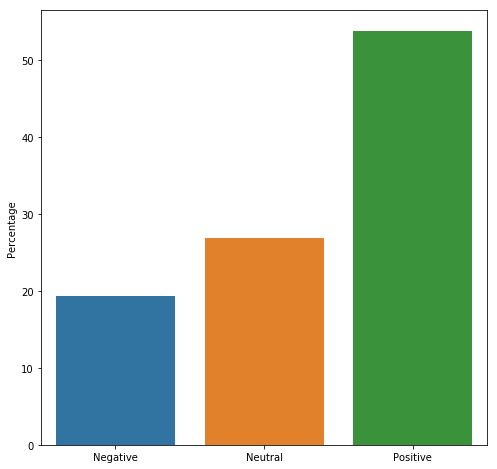

In [27]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(8, 8))

counts = df123.label.value_counts(normalize=True) * 100

sns.barplot(x=counts.index, y=counts, ax=ax)

ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
ax.set_ylabel("Percentage")

plt.show()

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0,0.5,'Count')

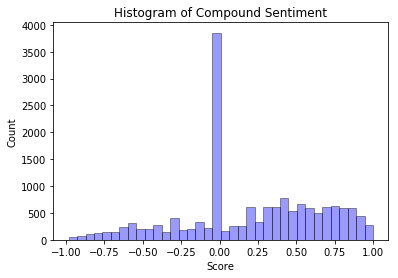

In [28]:

# seaborn histogram
sns.distplot(df123['compound'], hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Histogram of Compound Sentiment')
plt.xlabel('Score')
plt.ylabel('Count')

In [29]:
#https://github.com/llSourcell/Stock_Market_Prediction/blob/master/Generating%20Different%20Models.ipynb
#import numpy as np
#import pandas as pd
#from nltk.classify import NaiveBayesClassifier
#from nltk.corpus import subjectivity
#from nltk.sentiment import SentimentAnalyzer
#from nltk.sentiment.util import *
#import nltk
#nltk.downloader.download('vader_lexicon')

#sentence = 'paris shootout police officer suspected guman dead'
#from nltk.sentiment.vader import SentimentIntensityAnalyzer
#import unicodedata
#sid = SentimentIntensityAnalyzer()
#ss = sid.polarity_scores(sentence)
#ss

In [30]:
df123.index =data['publication_date']
df123.head()

,compound,headline,neg,neu,pos,label
publication_date,,,,,,
2015-05-12 05:05:04,-0.1027,Insight - U.S. media CEOs are top paid even in...,0.138,0.750,0.113,-1
2015-08-04 22:46:43,-0.1027,Disney shares drop after company lowers cable ...,0.333,0.463,0.204,-1
2015-09-08 22:58:07,0.1027,Infosys says cleared in U.S. visa probe by Lab...,0.000,0.865,0.135,1
2015-09-09 02:39:40,0.1027,Infosys says cleared in U.S. visa probe by Lab...,0.000,0.865,0.135,1
2015-10-21 16:03:16,0.0000,Disney's ESPN to eliminate over 300 positions ...,0.000,1.000,0.000,0


In [31]:
df123.to_csv('DIS_sent_news')

### Price analysis

In [32]:
df_price = pd.read_csv('disney_prices')

In [33]:
df_price.head()

,Unnamed: 0,adj_close,adj_high,adj_low,adj_open,adj_volume,close,date,frequency,high,intraperiod,low,open,volume
0,0,140.84,141.44,140.01,141.25,7339992.0,140.84,2019-07-22,daily,141.44,False,140.01,141.25,7707699.0
1,1,139.85,142.24,139.74,142.24,6109874.0,139.85,2019-07-19,daily,142.24,False,139.74,142.24,6109874.0
2,2,141.63,142.46,140.17,142.46,8035481.0,141.63,2019-07-18,daily,142.46,False,140.17,142.46,8035481.0
3,3,142.57,144.68,142.37,144.60,5296353.0,142.57,2019-07-17,daily,144.68,False,142.37,144.60,5296353.0
4,4,144.30,144.99,143.81,144.75,5854707.0,144.30,2019-07-16,daily,144.99,False,143.81,144.75,5854707.0


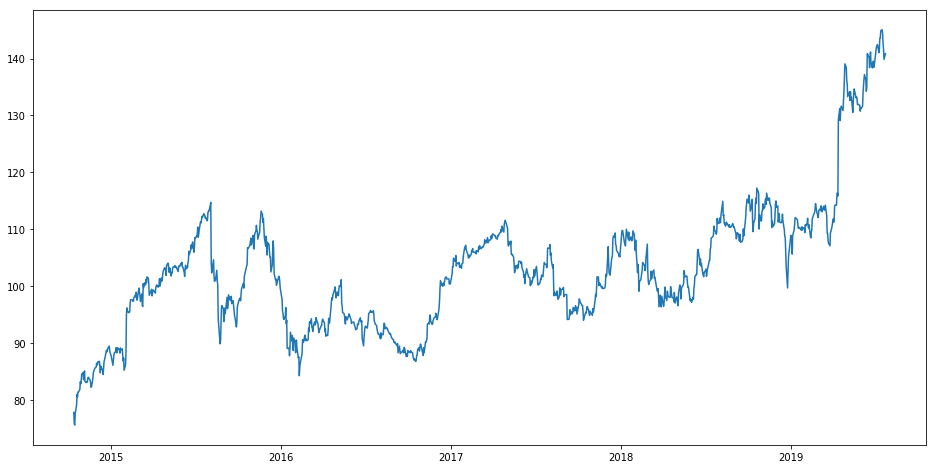

In [34]:
df_price['date']=pd.to_datetime(df_price.date,format='%Y-%m-%d')
df_price.index =df_price['date']
#plot
plt.figure(figsize=(16,8))
plt.plot(df_price['adj_close'], label='Close Price history')

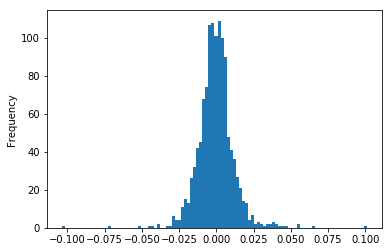

In [35]:
df_price['adj_close'].pct_change().plot.hist(bins=100)

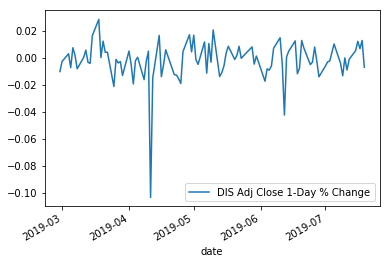

In [36]:
df_price['adj_close'][:100].pct_change().plot(label='DIS Adj Close 1-Day % Change',legend=True)

                     5d_close_pct  5d_close_future_pct
5d_close_pct              1.00000             -0.05922
5d_close_future_pct      -0.05922              1.00000


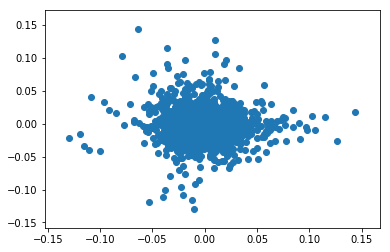

In [37]:
# Create 5-day % changes of Adj_Close for the current day, and 5 days in the future
df_price['5d_future_close'] = df_price['adj_close'].shift(-5)
df_price['5d_close_future_pct'] = df_price['5d_future_close'].pct_change(5)
df_price['5d_close_pct'] = df_price['adj_close'].pct_change(5)

# Calculate the correlation matrix between the 5d close pecentage changes (current and future)
corr = df_price[['5d_close_pct', '5d_close_future_pct']].corr()
print(corr)

# Scatter the current 5-day percent change vs the future 5-day percent change
plt.scatter(df_price['5d_close_pct'], df_price['5d_close_future_pct'])
plt.show()

In [38]:
import talib

In [39]:
feature_names = ['5d_close_pct']  # a list of the feature names for later

# Create moving averages and rsi for timeperiods of 14, 30, 50, and 200
for n in [14, 30, 50, 200]:

    # Create the moving average indicator and divide by Adj_Close
    df_price['ma' + str(n)] = talib.SMA(df_price['adj_close'].values,
                              timeperiod=n) / df_price['adj_close']
    # Create the RSI indicator
    df_price['rsi' + str(n)] = talib.RSI(df_price['adj_close'].values, timeperiod=n)
    
    # Add rsi and moving average to the feature name list
    feature_names = feature_names + ['ma' + str(n), 'rsi' + str(n)]
    
print(feature_names)

['5d_close_pct', 'ma14', 'rsi14', 'ma30', 'rsi30', 'ma50', 'rsi50', 'ma200', 'rsi200']


In [40]:
#df1.join(df123['compound'],how='right')

In [41]:
df1 = df_price.copy()

In [42]:
# Drop all na values
df_price = df_price.dropna()

# Create features and targets
# use feature_names for features; 5d_close_future_pct for targets
features = df_price[feature_names]
targets = df_price['5d_close_future_pct']

# Create DataFrame from target column and feature columns
feat_targ_df = df_price[['5d_close_future_pct'] + feature_names]

# Calculate correlation matrix
corr = feat_targ_df.corr()
print(corr)

                     5d_close_future_pct  5d_close_pct      ma14     rsi14  \
5d_close_future_pct             1.000000     -0.060177  0.027353  0.011326   
5d_close_pct                   -0.060177      1.000000 -0.852837  0.662038   
ma14                            0.027353     -0.852837  1.000000 -0.841443   
rsi14                           0.011326      0.662038 -0.841443  1.000000   
ma30                           -0.033768     -0.665148  0.873309 -0.933365   
rsi30                           0.003571      0.503970 -0.674751  0.913041   
ma50                           -0.014996     -0.526241  0.720220 -0.905913   
rsi50                          -0.012290      0.411148 -0.559326  0.788641   
ma200                           0.039641     -0.285323  0.389464 -0.535870   
rsi200                         -0.053009      0.212525 -0.286468  0.380473   

                         ma30     rsi30      ma50     rsi50     ma200  \
5d_close_future_pct -0.033768  0.003571 -0.014996 -0.012290  0.03964

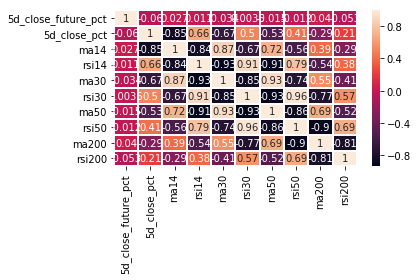

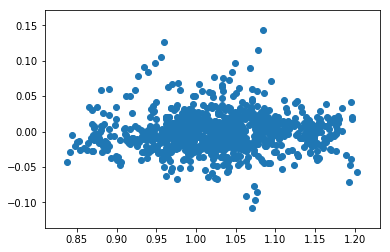

In [43]:
# Plot heatmap of correlation matrix
sns.heatmap(corr, annot=True,linewidths=1)
plt.yticks(rotation=0); plt.xticks(rotation=90)  # fix ticklabel directions
plt.tight_layout()  # fits plot area to the plot, "tightly"
plt.show()  # show the plot
plt.clf()  # clear the plot area

# Create a scatter plot of the most highly correlated variable with the target
plt.scatter(df_price['ma200'], df_price['5d_close_future_pct'])
plt.show()

In [44]:
# Import the statsmodels library with the alias sm
import statsmodels.api as sm

# Add a constant to the features
linear_features = sm.add_constant(features)

# Create a size for the training set that is 85% of the total number of samples
train_size = int(0.85 * features.shape[0])
train_features = linear_features[:train_size]
train_targets = targets[:train_size]
test_features = linear_features[train_size:]
test_targets = targets[train_size:]
print(linear_features.shape, train_features.shape, test_features.shape)
print(linear_features.shape, train_features.shape, test_features.shape)

(995, 10) (845, 10) (150, 10)
(995, 10) (845, 10) (150, 10)


In [45]:
from statsmodels.stats.outliers_influence import variance_inflation_factor    

def calculate_vif_(X, thresh=100):
    cols = X.columns
    variables = np.arange(X.shape[1])
    dropped=True
    while dropped:
        dropped=False
        c = X[cols[variables]].values
        vif = [variance_inflation_factor(c, ix) for ix in np.arange(c.shape[1])]

        maxloc = vif.index(max(vif))
    if max(vif) > thresh:
        print('dropping \'' + X[cols[variables]].columns[maxloc] + '\' at index: ' + str(maxloc))
        variables = np.delete(variables, maxloc)
        dropped=True

    print('Remaining variables:')
    print(X.columns[variables])
    return X[cols[variables]]

In [46]:
calculate_vif_(train_features,thresh=100)

dropping 'const' at index: 0
Remaining variables:
Index(['5d_close_pct', 'ma14', 'rsi14', 'ma30', 'rsi30', 'ma50', 'rsi50',
       'ma200', 'rsi200'],
      dtype='object')


,5d_close_pct,ma14,rsi14,ma30,rsi30,ma50,rsi50,ma200,rsi200
date,,,,,,,,,
2018-10-02,0.006587,0.981551,56.289041,0.981854,53.638770,0.978158,51.399906,1.035786,44.683400
2018-10-01,0.001896,0.991907,52.282784,0.993717,51.741483,0.990651,50.251031,1.047339,44.415422
2018-09-28,0.018819,0.986434,54.020094,0.987467,52.596544,0.985423,50.804155,1.039929,44.580089
2018-09-27,-0.000775,0.993414,51.427544,0.995137,51.385577,0.993636,50.073745,1.046766,44.410086
2018-09-26,-0.014541,0.999963,49.087813,1.001774,50.281145,1.001205,49.405323,1.052957,44.253672
2018-09-25,-0.034251,1.013986,44.900064,1.014799,48.239398,1.015003,48.156647,1.066126,43.957473
2018-09-24,-0.029852,1.021821,42.761670,1.021746,47.161084,1.022726,47.490004,1.072742,43.797112
2018-09-21,-0.055926,1.043271,37.466088,1.042237,44.335746,1.043714,45.710586,1.094179,43.359014
2018-09-20,-0.038090,1.031075,41.483389,1.029508,46.056660,1.031613,46.758466,1.080699,43.650625


In [47]:
# Create the linear model and complete the least squares fit
model = sm.OLS(train_targets, train_features)
results = model.fit()  # fit the model
print(results.summary())

# examine pvalues
# Features with p <= 0.05 are typically considered significantly different from 0
print(results.pvalues)

# Make predictions from our model for train and test sets
train_predictions = results.predict(train_features)
test_predictions = results.predict(test_features)

                             OLS Regression Results                            
Dep. Variable:     5d_close_future_pct   R-squared:                       0.106
Model:                             OLS   Adj. R-squared:                  0.096
Method:                  Least Squares   F-statistic:                     10.96
Date:                 Wed, 07 Aug 2019   Prob (F-statistic):           3.01e-16
Time:                         23:18:27   Log-Likelihood:                 1930.6
No. Observations:                  845   AIC:                            -3841.
Df Residuals:                      835   BIC:                            -3794.
Df Model:                            9                                         
Covariance Type:             nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.9366      0.207    

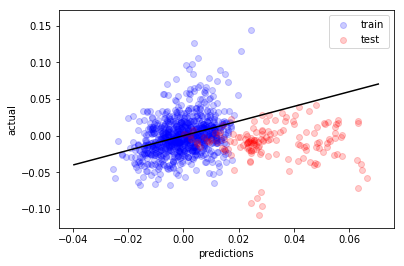

In [48]:
# Scatter the predictions vs the targets with 80% transparency
plt.scatter(train_predictions, train_targets, alpha=0.2, color='b', label='train')
plt.scatter(test_predictions, test_targets, alpha= 0.2, color='r', label='test')

# Plot the perfect prediction line
xmin, xmax = plt.xlim()
plt.plot(np.arange(xmin, xmax, 0.01), np.arange(xmin, xmax, 0.01), c='k')

# Set the axis labels and show the plot
plt.xlabel('predictions')
plt.ylabel('actual')
plt.legend()  # show the legend
plt.show()